In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os


load_dotenv('../.env')
engine = create_engine(os.getenv('DB_URL'))

df = pd.read_sql(
    """
    select revenue_month, sum(mrr) as total_mrr
    from gold.fact_revenue
    group by 1
    order by 1    
    """,
    engine
)

df['revenue_month'] = pd.to_datetime(df['revenue_month'])
print(df)

               revenue_month   total_mrr
0  2010-11-30 18:30:00+00:00   569599.12
1  2010-12-31 18:30:00+00:00   563799.53
2  2011-01-31 18:30:00+00:00   445155.14
3  2011-02-28 18:30:00+00:00   585147.24
4  2011-03-31 18:30:00+00:00   456482.41
5  2011-04-30 18:30:00+00:00   660961.97
6  2011-05-31 18:30:00+00:00   655654.27
7  2011-06-30 18:30:00+00:00   593317.57
8  2011-07-31 18:30:00+00:00   637342.95
9  2011-08-31 18:30:00+00:00   940998.56
10 2011-09-30 18:30:00+00:00  1006090.88
11 2011-10-31 18:30:00+00:00  1138603.96
12 2011-11-30 18:30:00+00:00   512702.81


In [ ]:
# 3-Month Rolling Average
df['rolling_3m'] = df['total_mrr'].rolling(3).mean()
df['rolling_6m'] = df['total_mrr'].rolling(6).mean()

next_month_frecast = df['rolling_3m'].iloc[-1]
print(f"3M Rolling Average Forecast (next month): £{next_month_frecast:,.2f}")

3M Rolling Average Forecast (next month): 885,799.22


In [6]:
# Linear Regression
df['x'] = range(len(df))
mask = df['total_mrr'].notna()

slope, intercept, r, p, se = stats.linregress(
    df['x'][mask], df['total_mrr'][mask]
)

next_x = len(df)
m1 = slope * next_x + intercept
m2 = slope * (next_x+1) + intercept
m3 = slope * (next_x+2) + intercept

print(f'Slope:        £{slope:,.0f} per month')
print(f'R²:           {r**2:.4f}')
print(f'M+1 Forecast: £{m1:,.2f}')
print(f'M+2 Forecast: £{m2:,.2f}')
print(f'M+3 Forecast: £{m3:,.2f}')

Slope:        £33,725 per month
R²:           0.3681
M+1 Forecast: £910,374.26
M+2 Forecast: £944,099.63
M+3 Forecast: £977,825.00


In [ ]:
# Churn-Adjusted Projection
churn_df = pd.read_sql("""
    SELECT
        dc.segment,
        SUM(fr.mrr)                  AS current_mrr,
        AVG(fr.churn_probability)    AS churn_rate
    FROM gold.fact_revenue fr
    JOIN gold.dim_customer dc
        ON fr.customer_surrogate_key = dc.customer_surrogate_key
    WHERE fr.revenue_month = (
        SELECT MAX(revenue_month) FROM gold.fact_revenue
    )
    GROUP BY 1
""", engine)

churn_df['m1_projected'] = churn_df['current_mrr'] * (1 - churn_df['churn_rate'])
churn_df['m2_projected'] = churn_df['current_mrr'] * (1 - churn_df['churn_rate'])**2
churn_df['m3_projected'] = churn_df['current_mrr'] * (1 - churn_df['churn_rate'])**3
churn_df['rev_at_risk']  = churn_df['current_mrr'] - churn_df['m3_projected']

print(churn_df[['segment','current_mrr','m1_projected','m3_projected','rev_at_risk']].round(2))
print(f"\nTotal 90-day revenue at risk: £{churn_df['rev_at_risk'].sum():,.2f}")

  segment  current_mrr  m1_projected  m3_projected  rev_at_risk
0     MID     99358.25      72893.62      39233.82     60124.43
1    HIGH     86810.67      65457.50      37216.19     49594.48
2     VIP    312200.85     258285.34     176779.17    135421.68
3     LOW     14333.04      11496.69       7396.77      6936.27

Total 90-day revenue at risk: £252,076.85


✓ Chart saved to docs/forecast_chart.png


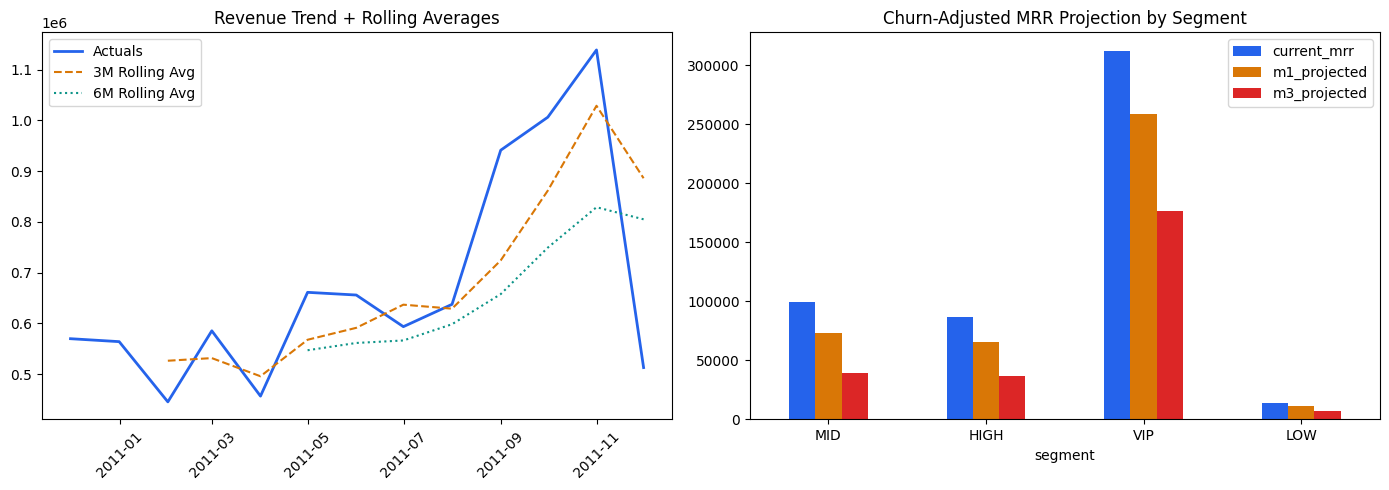

In [10]:
# Charts for all 3 models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Actuals + rolling averages
axes[0].plot(df['revenue_month'], df['total_mrr'],
             label='Actuals', lw=2, color='#2563EB')
axes[0].plot(df['revenue_month'], df['rolling_3m'],
             label='3M Rolling Avg', ls='--', color='#D97706')
axes[0].plot(df['revenue_month'], df['rolling_6m'],
             label='6M Rolling Avg', ls=':', color='#0D9488')
axes[0].set_title('Revenue Trend + Rolling Averages', fontsize=12)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Right: Churn-adjusted segment projection
churn_df.set_index('segment')[['current_mrr','m1_projected','m3_projected']]\
    .plot(kind='bar', ax=axes[1], color=['#2563EB','#D97706','#DC2626'])
axes[1].set_title('Churn-Adjusted MRR Projection by Segment', fontsize=12)
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('../docs/forecast_chart.png', dpi=150)
print('✓ Chart saved to docs/forecast_chart.png')